In [32]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import pandas as pd
import json

def microseconds(x, pos):
    'The two args are the value and tick position'
    return '%i µs' % x

def milliseconds(x, pos):
    'The two args are the value and tick position'
    return '%i ms' % (x*1e-3)

def kilobytes(x, pos):
    'The two args are the value and tick position'
    return '%i kB' % x

def megabytes(x, pos):
    'The two args are the value and tick position'
    return '%i MB' % (x*1e-3)

def plot_all_groups():
    group_columns = get_column_names('custom')
    group_columns.remove('remainder_size')
    group_columns.remove('size')
    group_columns.remove('run_time')
    grouped_data = get_results('custom').groupby(group_columns)
    for group_info in list(grouped_data.groups):
        for i in range(0, len(group_columns)):
            print(group_columns[i] + ": " + str(group_info[i]))
        sub_groups = grouped_data.get_group(group_info).groupby('remainder_size')
        run_time_data = []
        for remainder_size in list(sub_groups.groups):
            run_time_data.append(sub_groups.get_group(remainder_size)['run_time']) 
        plot_labels = ['None', '2', '4', '8', '16'][0:len(run_time_data)]
        boxplot('Table Scan Runtime', run_time_data, plot_labels)
    
def boxplot(title, subtitle, data, labels, unit='milli', start_at_zero=True): 
    runtimes = []
    sizes = []
    for series in data:
        runtimes.append(series['run_time'])
        sizes.append(series['size'].iloc[0])
    
    size_formatter = FuncFormatter(megabytes)
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(size_formatter)
    ax.set_title("Additional Memory Space Consumption")
    
    plt.bar(range(len(sizes)), sizes, width=1/1.5, color="blue", tick_label=labels)
    plt.show()
    
    formatter = FuncFormatter(microseconds)
    if unit == 'milli':
        formatter = FuncFormatter(milliseconds)
    elif unit == 'micro':
        formatter = FuncFormatter(microseconds)
    else: 
        print('unknown unit')

    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    plt.rc('xtick', labelsize=8) 
    
    plt.boxplot(runtimes, labels=labels, showfliers=False)
    
    #bp_dict = plt.boxplot(data, labels=labels, showfliers=False)
    #for line in bp_dict['medians']:
    #    # get position data for median line
    #    print(line)
    #    x, y = line.get_xydata()[1] # top of median line
    #    # overlay median value
    #    plt.text(x, y - 100, '%d' % y, horizontalalignment='center') # draw above, centered
    
    plt.title(title + "\n" + subtitle)
    #plt.xlabel('remainder size')
    plt.ylabel('run time')
    if start_at_zero:
        ax.set_ylim(ymin=0)
    file_name = title.replace(" ", "_").replace(":", "")
    plt.savefig('plots/{}.pgf'.format(file_name))
    plt.savefig('plots/{}.pdf'.format(file_name))
    plt.show()
    
def get_column_names(benchmark): 
    table_info = json.load(open(benchmark + '_results.csv.json','r'))
    #print(json.dumps(table_info, indent=2, sort_keys=False))
    column_names = []
    for column in table_info["columns"]:
        column_names.append(column["name"])
    return column_names
    
def get_results(benchmark):
    return pd.read_csv(benchmark + '_results.csv', header=None, names=get_column_names(benchmark))

def select_custom(data, data_type, pruning_rate, remainder_size, dictionary, btree, art):
    return data[(data.data_type == data_type) &
                (data.pruning_rate == pruning_rate) &
                (data.remainder_size == remainder_size) & 
                (data.dictionary == dictionary) & 
                (data.btree == btree) & 
                (data.art == art)]

def select_tpcc(data, remainder_size, dictionary, btree, art):
    return data[(data.table_name == 'ORDER-LINE') &
                (data.column_name == 'OL_I_ID') &
                (data.warehouse_size == 10) & 
                (data.chunk_size == 100000) &
                (data.remainder_size == remainder_size) & 
                (data.dictionary == dictionary) & 
                (data.btree == btree) & 
                (data.art == art)]

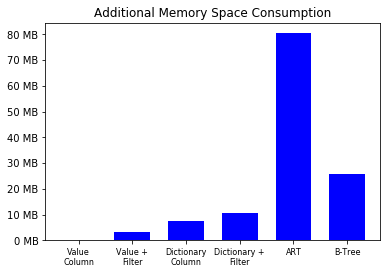

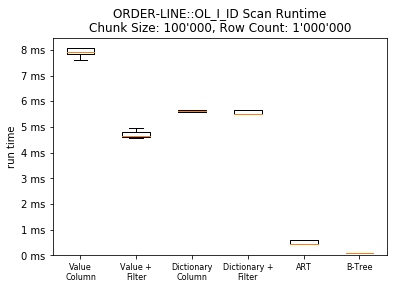

In [33]:
data = get_results('tpcc')
btree_data        = select_tpcc(data, remainder_size=0, dictionary=0, btree=1, art=0)
art_data          = select_tpcc(data, remainder_size=0, dictionary=1, btree=0, art=1)
value_filter_data = select_tpcc(data, remainder_size=4, dictionary=0, btree=0, art=0)
dictionary_data   = select_tpcc(data, remainder_size=0, dictionary=1, btree=0, art=0)
dict_filter_data  = select_tpcc(data, remainder_size=4, dictionary=1, btree=0, art=0)
value_column_data = select_tpcc(data, remainder_size=0, dictionary=0, btree=0, art=0)
plot_data = [value_column_data, value_filter_data, dictionary_data, dict_filter_data, art_data, btree_data]
labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'Dictionary +\nFilter', 'ART', 'B-Tree']
boxplot('ORDER-LINE::OL_I_ID Scan Runtime', 'Chunk Size: 100\'000, Row Count: 1\'000\'000', plot_data, labels)

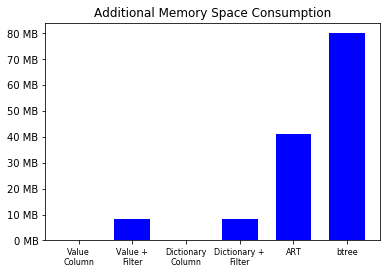

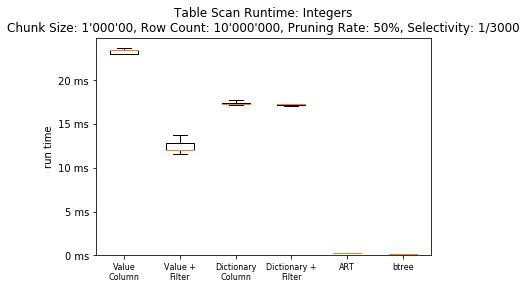

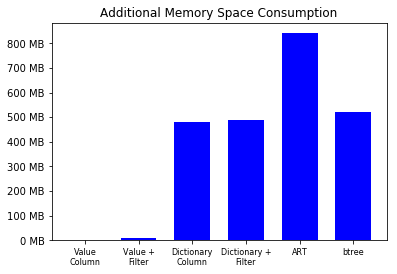

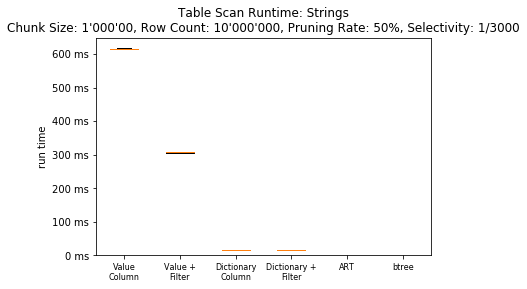

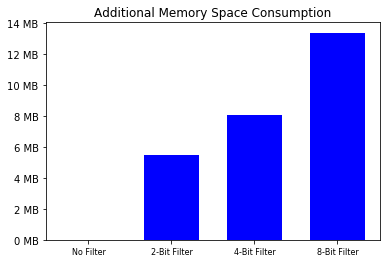

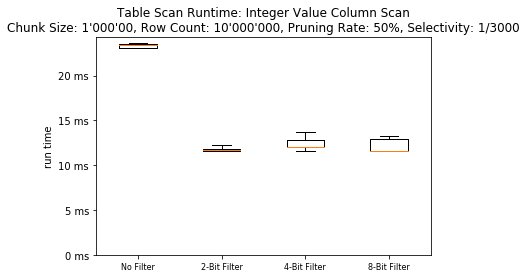

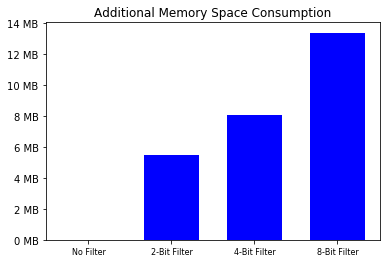

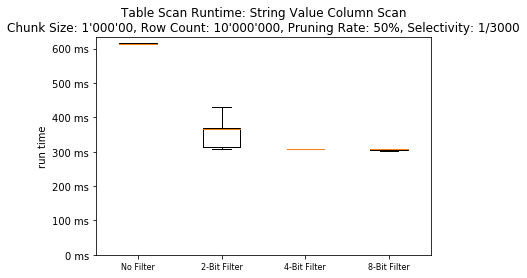

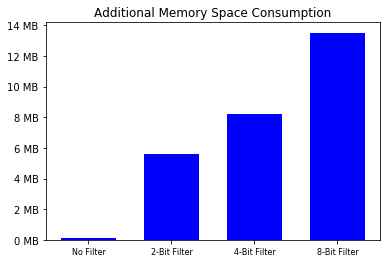

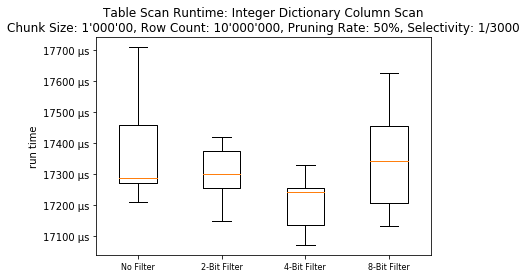

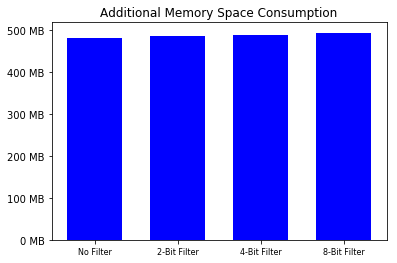

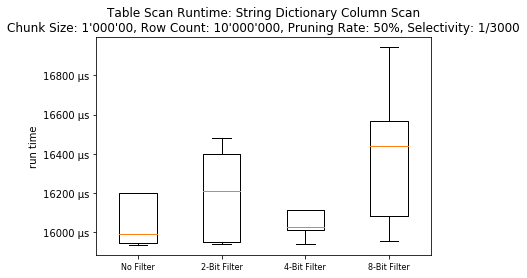

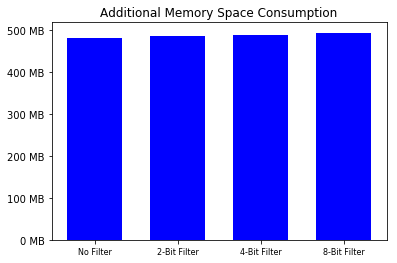

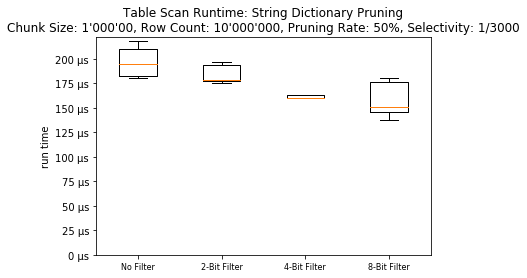

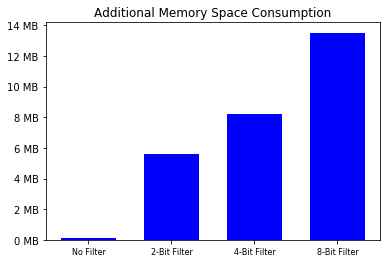

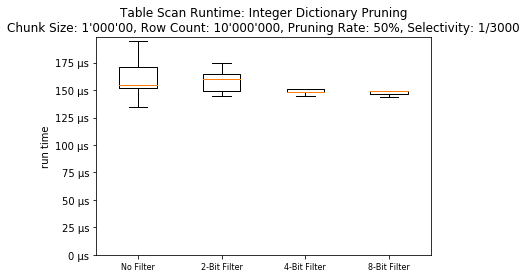

In [35]:
subtitle = 'Chunk Size: 1\'000\'00, Row Count: 10\'000\'000, Pruning Rate: 50%, Selectivity: 1/3000'

data = get_results('custom')
btree_data        = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=1, art=0)
art_data          = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=1)
value_filter_data = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
dictionary_data   = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
dict_filter_data  = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
value_column_data = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
plot_data = [value_column_data, value_filter_data, dictionary_data, dict_filter_data, art_data, btree_data]
labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'Dictionary +\nFilter', 'ART', 'btree']
boxplot('Table Scan Runtime: Integers', subtitle, plot_data, labels)

btree_data        = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=1, art=0)
art_data          = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=1)
value_filter_data = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
dictionary_data   = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
dict_filter_data  = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
value_column_data = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
plot_data = [value_column_data, value_filter_data, dictionary_data, dict_filter_data, art_data, btree_data]
labels = ['Value\nColumn', 'Value +\nFilter', 'Dictionary\nColumn', 'Dictionary +\nFilter', 'ART', 'btree']
boxplot('Table Scan Runtime: Strings', subtitle, plot_data, labels)

series0 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
series2 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=2, dictionary=0, btree=0, art=0)
series4 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
series8 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=8, dictionary=0, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: Integer Value Column Scan', subtitle, plot_data, labels)

series0 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=0, btree=0, art=0)
series2 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=2, dictionary=0, btree=0, art=0)
series4 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=0, btree=0, art=0)
series8 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=8, dictionary=0, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: String Value Column Scan', subtitle, plot_data, labels)

series0 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select_custom(data, data_type='int', pruning_rate=0.5, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: Integer Dictionary Column Scan', subtitle, plot_data, labels, 'micro', False)

series0 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select_custom(data, data_type='string', pruning_rate=0.5, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: String Dictionary Column Scan', subtitle, plot_data, labels, 'micro', False)

series0 = select_custom(data, data_type='string', pruning_rate=1.0, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select_custom(data, data_type='string', pruning_rate=1.0, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select_custom(data, data_type='string', pruning_rate=1.0, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select_custom(data, data_type='string', pruning_rate=1.0, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: String Dictionary Pruning', subtitle, plot_data, labels, 'micro')

series0 = select_custom(data, data_type='int', pruning_rate=1.0, remainder_size=0, dictionary=1, btree=0, art=0)
series2 = select_custom(data, data_type='int', pruning_rate=1.0, remainder_size=2, dictionary=1, btree=0, art=0)
series4 = select_custom(data, data_type='int', pruning_rate=1.0, remainder_size=4, dictionary=1, btree=0, art=0)
series8 = select_custom(data, data_type='int', pruning_rate=1.0, remainder_size=8, dictionary=1, btree=0, art=0)
plot_data = [series0, series2, series4, series8]
labels = ['No Filter', '2-Bit Filter', '4-Bit Filter', '8-Bit Filter']
boxplot('Table Scan Runtime: Integer Dictionary Pruning', subtitle, plot_data, labels, 'micro')